<a href="https://colab.research.google.com/github/padibi4/cap-comp215/blob/main/Copy_of_lab05_CA_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 5 (Elementary Cellular Automata)
-----------------------------------------------
#### Name:
#### Date:

This lab exercise is an introduction to the elementary [Cellular Automata](https://en.wikipedia.org/wiki/Elementary_cellular_automaton) studied by [Stephen Wolfram](https://en.wikipedia.org/wiki/Stephen_Wolfram#Complex_systems_and_cellular_automata).

**New Python concepts**:
  * **[NumPy](https://numpy.org)** is an open-source scientific computing package.  We will be using numpy for the remainder of the term.
  * 1D and 2D [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html) -  a rectangular grid with efficient matrix operations.

**New Computation concepts**:
  * **bit sequence** (a.k.a. binary number) - using a sequence of 0's and 1's to efficiently represent a data structure and processes.

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## CA Fundamentals
Both the textbook and our week5 notebook develop some fundamental operations for simulating Elementary CA.
Some of the code developed in class is reproduced here without deriving all the ideas - review `week05` notebook for the full story.
The sliding dot product algorithm in `rule_indexes` is implemented with [numpy.correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html).  It's behaviour is identical to the derivation from class.

#### Notes
* we use `np.pad(array, 1, mode='wrap')` to pad state vector with 1 extra value at both ends, equal to the last value at the opposing end of the vector.  This strategy avoids [edge effects](https://en.wikipedia.org/wiki/Boundary_problem_(spatial_analysis)#Types_and_examples).
* since the rule is an `np.array`, we use "vector indexing" here to index a whole row at once:  `next_row=rule[indexes]`  See `foundations/numpy_1D_arrays` for details.


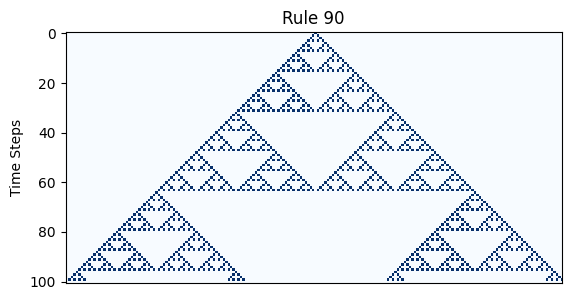

In [2]:
POWERS_OF_2 = np.array((4, 2, 1))

def rule_indexes(state):
    """ Return vector of rule indexes - one index for each 3-cell neighbourhood in the CA state vector. """
    # numpy's version of the "sliding dot product" algorithm;  "pad" ends of state array with extra 0 cell to mitigate edge effects
    return np.correlate(np.pad(state, 1, mode='constant'), POWERS_OF_2, mode='valid')

assert all( rule_indexes(np.array([1,1,0,0,1,0,0,0])) == [3, 6, 4, 1, 2, 4, 0, 0] )


def transition(state, rule):
    """ Return the vector resulting from a transition of given CA state under the given 8-bit rule """
    indexes = rule_indexes(state)
    return np.array(rule[indexes])  # "vector indexing" replaces: [rule[i] for i in indexes]

rule_110 = (0,1,1,0,1,1,1,0)[::-1]
assert all( transition(np.array((0,0,1,1,1,0,0,0,1,1,0)), np.array(rule_110)) == (0,1,1,0,1,0,0,1,1,1,0))


# This algorithm is from the textbook - it uses numpy to do a decimal to binary conversion.
def get_lookup_table(rule):
    """
    Return the 8-bit transition vector for the given elementary CA rule number.
    rule: int 0-255
    returns: transition lookup table - a 8 element vector of 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    return np.unpackbits(rule)[::-1]

assert np.all( get_lookup_table(110) == rule_110 )


def single_centre_array(n_cells):
    """ Return a binary 1D array with given number of cells, all zeros except a single 1 in the centre cell """
    array = np.zeros(n_cells, dtype=np.uint8)
    array[n_cells//2] = 1
    return array

assert np.all( single_centre_array(7) == (0,0,0,1,0,0,0) )


def simulate_ca(n_cells, n_steps, rule):
    """ Generate a CA with given number of cells, plot progression of rule for given number of time steps """
    start_state = single_centre_array(n_cells)
    # create a stack of "empty" state vectors, one for each time step
    ca_timesteps = np.vstack([start_state, np.zeros((n_steps, len(start_state)), dtype=np.uint8)])
    # run the simulation
    for t in range(1, n_steps):
        ca_timesteps[t] = transition(ca_timesteps[t-1], rule)
    return ca_timesteps


def plot_ca(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set(
        title=title,
        ylabel='Time Steps',
    )
    # Turn off axes labels and tick marks
    axes.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

rule_90 = get_lookup_table(90)
ca_timesteps = simulate_ca(200, 100, rule_90)
plot_ca(ca_timesteps, title=f'Rule 90')

## Exercise 1: Additional Start States
In Wolfram's original experiments, he starts with a CA that is all zeros except the centre cell.
This is reproduced by the `single_centre_array` function above.
It would be interesting to experiment with other start states...

Write 2 functions, each of which returns a 1-D `numpy.array` (vector) configured in a specific state:
1. `from_string_array` takes a text string of 0's and 1's and returns a 1D array with matching integer values
2. `random_array` takes a float $ p where 0 <= p <= 1 $ as input and returns a 1D array $a$, where probability $a[i] == 1$ is $p$

*Tip*: both problems are most easily solved using list comprehensions!

In [3]:
def from_string_array(str):
  return [int(char) for char in str]

print(from_string_array("1010110"))

[1, 0, 1, 0, 1, 1, 0]


In [4]:
import numpy as np

def random_array(n,p):
  return np.random.choice([0,1], size=n, p=[1-p, p])

result= random_array(5,0.2)
print(result)

[0 0 0 0 0]


## Exercise 2: A Cell1D class
Develop your own `Cell1D` class that uses the functions above to implement its fundamental operations.
The `Cell1D` class from the textbook may provide some ideas, but you may find it more confusing than helpful.
The goal here is to improve on the design of that class, so it might be better to just start over...

* Initialize a `Cell1D` with a `rule` number and an array representing the CA `start_state`
  *Tip*: initialize a 2-D array with just a single row to define the CA's data structure correctly.
* Add a `simulate` method that takes the number of steps to simulate as input (note: my solution is just 4 lines of code)
  *Tip*: you can reuse the algorithm from `simulate_ca` above.
* Add a `step` method.  Unlike the textbook, our `step` method is just a convenience method - it just `simulate`s a single step.
* Add a `draw` method.  Just call `plot_ca` to do the actual work.

Note: this is *not* a `dataclass` - you will need an `__init__` method.

In [5]:
import numpy as np

In [6]:
class CellID:
  def __init__(self, rule_number, start_state):
    self.rule_number=rule_number

In [7]:
num_columns= 5

array_2d= [0] * num_columns
print(array_2d)

[0, 0, 0, 0, 0]


In [16]:
# class Cell1D:
#     def __init__(self, rule_number, start_state):
#         self.rule_number = rule_number
#         self.start_state = start_state
#         self.rows = len(start_state)
#         self.cols = len(start_state[0])



# rule_number = 30
# start_state = [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
# ca = Cell1D(rule_number, start_state)


In [17]:
# def simulate_ca(n_cells, n_steps, rule):
#     start_state = single_centre_array(n_cells)
#     ca_timesteps = np.vstack([start_state, np.zeros((n_steps, len(start_state)), dtype=np.uint8)])
#     for t in range(1, n_steps):
#         ca_timesteps[t] = transition(ca_timesteps[t-1], rule)
#     return ca_timesteps

In [19]:
# class Cell1D:
#     def __init__(self, rule_number, start_state):
#         self.rule_number = rule_number
#         self.start_state = start_state
#         self.rows = len(start_state)
#         self.cols = len(start_state[0])

#     def step(self):
#         next_state = []
#         current_row = self.start_state[0]
#         for j in range(self.cols):
#             left = current_row[(j - 1) % self.cols]
#             center = current_row[j]
#             right = current_row[(j + 1) % self.cols]
#             next_state.append(self.evolve_cell(left, center, right))
#         self.start_state = [next_state]

#     def evolve(self, steps):
#         for _ in range(steps):
#             self.step()

#     def evolve_cell(self, left, center, right):
#         # Your logic for determining the next state of a cell based on its neighbors and the rule number goes here
#         pass

# # Example usage
# rule_number = 30
# start_state = [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]  # Example start state, 1 row
# ca = Cell1D(rule_number, start_state)

# # Perform a single step
# ca.step()


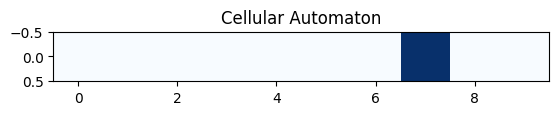

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ca(array, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes. 1's will be dark blue, 0's will be light blue.

    :param array: 2D array representing the cellular automaton state
    :param title: Title of the plot
    :param cmap: Colormap for plotting
    :param options: Additional keyword arguments passed directly to `plt.imshow()`
    """
    plt.title(title)
    plt.imshow(array, cmap=cmap, **options)
    plt.show()

class Cell1D:
    def __init__(self, rule_number, start_state):
        self.rule_number = rule_number
        self.start_state = start_state

    def simulate(self, n_steps):
        for _ in range(n_steps):
            self.step()

    def step(self):
        next_state = []
        current_row = self.start_state[0]
        for j in range(len(current_row)):
            left = current_row[(j - 1) % len(current_row)]
            center = current_row[j]
            right = current_row[(j + 1) % len(current_row)]
            next_state.append(self.evolve_cell(left, center, right))
        self.start_state = [next_state]

    def draw(self):
        # Convert start_state to a numerical array
        numeric_array = np.array(self.start_state)
        plot_ca(numeric_array, title='Cellular Automaton')

    def evolve_cell(self, left, center, right):
        # Placeholder implementation, replace with your own logic
        return center  # No change in state

# Example usage
rule_number = 30
start_state = [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]  # Example start state, 1 row
ca = Cell1D(rule_number, start_state)

# Simulate for 100 steps
ca.simulate(100)
ca.draw()


## Run some Experiments
With your new `Cell1D` class, run some experiments to explore the Elementary CA's.

Wolfram identifies 4 "classes" of Elementary Cellular Automata:
    a) rapidly converge to a uniform static state.
    b) rapidly converge to a stable repeating pattern.
    c) generate non-repeating, random states.
    d) generate chaos, with areas of repetitive or stable states, but also structures that interact in complex ways.

### Exercise 3

1. It will be convenient to abstract the steps needed to construct, simulate, and draw a CA - develop a small `experiment` function to do so.

2. Identify a rule that exemplifies each of the 4 CA classes.
   Create a 2x2 grid of plots that shows an example simulation for each class of CA side-by-side.
   You can simply re-purpose the example code below.

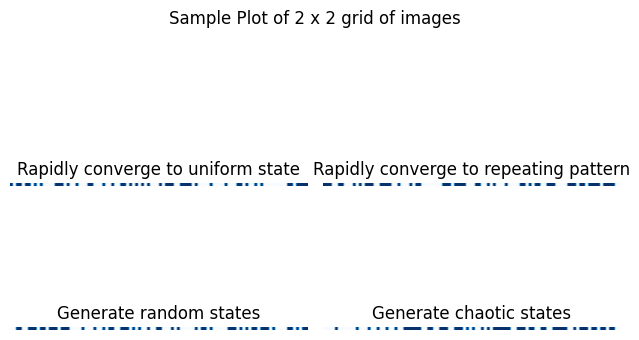

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def axes_layout(nrows=1, ncols=1, fig_title=None, **kwargs):
    """Layout nrows x ncols axes with sensible defaults. kwargs passed directly to `plt.subplots()`"""
    kwargs = {**dict(layout='tight'), **kwargs}
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, **kwargs)
    if fig_title:
        fig.suptitle(fig_title)
    return axes

def plot_ca(array, ax=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes. 1's will be dark blue, 0's will be light blue.

    :param array: 2D array representing the cellular automaton state
    :param ax: Axes to plot on. If None, current axes will be used.
    :param title: Title of the plot
    :param cmap: Colormap for plotting
    :param options: Additional keyword arguments passed directly to `ax.imshow()`
    """
    ax.set_title(title)
    ax.imshow(array, cmap=cmap, **options)
    ax.axis('off')

class Cell1D:
    def __init__(self, rule_number, start_state):
        self.rule_number = rule_number
        self.start_state = start_state

    def simulate(self, n_steps):
        for _ in range(n_steps):
            self.step()

    def step(self):
        next_state = []
        current_row = self.start_state[0]
        for j in range(len(current_row)):
            left = current_row[(j - 1) % len(current_row)]
            center = current_row[j]
            right = current_row[(j + 1) % len(current_row)]
            next_state.append(self.evolve_cell(left, center, right))
        self.start_state = [next_state]

    def evolve_cell(self, left, center, right):
        # Replace this with the specific rule logic for the cellular automaton
        return (left ^ center ^ right)  # Example rule (XOR)

def experiment(rule_number, start_state, n_steps):
    ca = Cell1D(rule_number, start_state)
    ca.simulate(n_steps)
    return ca.start_state

# Example usage to generate a 2x2 grid of plots
rules = [0, 18, 30, 110]
n_steps = 100

fig_title = 'Sample Plot of 2 x 2 grid of images'
axes = axes_layout(2, 2, fig_title=fig_title)

for rule, ax, title in zip(rules, axes.flat, ('Rapidly converge to uniform state', 'Rapidly converge to repeating pattern', 'Generate random states', 'Generate chaotic states')):
    start_state = np.random.randint(2, size=(1, 100))  # Random initial state
    simulated_state = experiment(rule, start_state, n_steps)
    plot_ca(np.array(simulated_state), ax=ax, title=title)

plt.tight_layout()
plt.show()


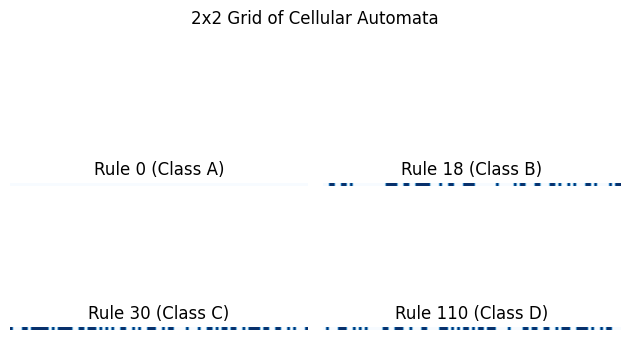

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def axes_layout(nrows=1, ncols=1, fig_title=None, **kwargs):
    """Layout nrows x ncols axes with sensible defaults. kwargs passed directly to `plt.subplots()`"""
    kwargs = {**dict(layout='tight'), **kwargs}
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, **kwargs)
    if fig_title:
        fig.suptitle(fig_title)
    return axes

def plot_ca(array, ax=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes. 1's will be dark blue, 0's will be light blue.

    :param array: 2D array representing the cellular automaton state
    :param ax: Axes object to plot on, if None, current axes will be used
    :param title: Title of the plot
    :param cmap: Colormap for plotting
    :param options: Additional keyword arguments passed directly to `plt.imshow()`
    """
    ax = ax or plt.gca()
    ax.set_title(title)
    ax.imshow(array, cmap=cmap, **options)
    ax.axis('off')

class Cell1D:
    def __init__(self, rule_number, start_state):
        self.rule_number = rule_number
        self.start_state = start_state

    def simulate(self, n_steps):
        for _ in range(n_steps):
            self.step()

    def step(self):
        next_state = []
        current_row = self.start_state[0]
        for j in range(len(current_row)):
            left = current_row[(j - 1) % len(current_row)]
            center = current_row[j]
            right = current_row[(j + 1) % len(current_row)]
            next_state.append(self.evolve_cell(left, center, right))
        self.start_state = [next_state]

    def draw(self, ax=None):
        # Convert start_state to a numerical array
        numeric_array = np.array(self.start_state)
        plot_ca(numeric_array, ax=ax, title='Cellular Automaton')

    def evolve_cell(self, left, center, right):
        # Apply the rule for the cellular automaton
        # This function will be different for each rule
        if self.rule_number == 0:
            return 0  # Uniform static state
        elif self.rule_number == 18:
            return left ^ right  # Stable repeating pattern
        elif self.rule_number == 30:
            return left ^ center ^ right  # Non-repeating, random states
        elif self.rule_number == 110:
            return left ^ (~center & right)  # Chaos, complex structures

# Define rules for each class
rules = {
    'a': 0,
    'b': 18,
    'c': 30,
    'd': 110
}

# Simulate each rule and plot results
fig_title = '2x2 Grid of Cellular Automata'
axes = axes_layout(2, 2, fig_title=fig_title)
for ax, (cls, rule) in zip(axes.flat, rules.items()):
    start_state = np.random.randint(2, size=(1, 100))  # Random initial state
    ca = Cell1D(rule, start_state)
    ca.simulate(100)
    numeric_array = np.array(ca.start_state)
    plot_ca(numeric_array, ax=ax, title=f'Rule {rule} (Class {cls.upper()})')

plt.tight_layout()
plt.show()


In [37]:
# def run_experiment(rule_num, start_state, steps):
#     cell = Cell1D(rule_num, start_state)
#     cell.draw(steps)

# def display_experiment(rule_nums, start_states, steps):
#     num_classes = len(rule_nums)
#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))
#     for i in range(num_classes):
#         row = i // 2
#         col = i % 2
#         ax = axes[row, col]
#         rule_num = rule_nums[i]
#         start_state = start_states[i]
#         cell = Cell1D(rule_num, start_state)
#         states = list(cell.simulate(steps))
#         ax.imshow(states, cmap='binary', interpolation='nearest')
#         ax.set_title(f"Rule {rule_num}")
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Rules exemplifying each class:
# class_rules = {
#     'a': 30,  # Rapidly converge to a uniform static state
#     'b': 18,  # Rapidly converge to a stable repeating pattern
#     'c': 22,  # Generate non-repeating, random states
#     'd': 110, # Generate chaos, with areas of repetitive or stable states, but also structures that interact in complex ways
# }

# # Start states for each class
# start_states = {
#     'a': [0] * 51,
#     'b': [0] * 51,
#     'c': [0] * 51,
#     'd': [0] * 51,
# }

# # Setting a single cell as 'on' to start for classes a and b
# start_states['a'][25] = 1
# start_states['b'][25] = 1

# # Random start state for class c
# start_states['c'] = np.random.randint(0, 2, 51)

# # Start state with a single 'on' cell for class d
# start_states['d'][25] = 1

# # Number of steps to simulate
# steps = 50

# # Run experiment for each class
# display_experiment([class_rules[class_] for class_ in 'abcd'], [start_states[class_]for class_ in 'abcd'], steps)

In [11]:
# Solution for Ex. 3 here...

#### Sample code for creating a 2x2 grid of plots

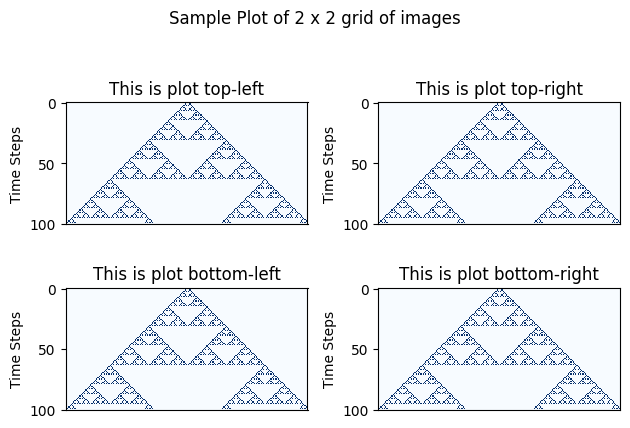

In [12]:
def axes_layout(nrows=1, ncols=1, fig_title=None, **kwargs):
    """ layout nrows x ncols axes with sensible defaults.  kwargs passed directly to `plt.subplots()`"""
    kwargs = {**dict(layout='tight'), **kwargs}
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, **kwargs)
    if fig_title:
        fig.suptitle(fig_title)
    return axes

# Example: plot 4 plots in a 2x2 grid - plots are labelled so it's clear which is which.
axes = axes_layout(2, 2, fig_title='Sample Plot of 2 x 2 grid of images')
for ax, title in zip(axes.flat, ('top-left', 'top-right', 'bottom-left', 'bottom-right' )):
    plot_ca(ca_timesteps, axes=ax, title=f'This is plot {title}')

## Exercise 4:  Thought Experiments
Think about some of the questions that arise from this experiment.  Provide some concise answer that capture you thinking...
1. What is it about these experiments that requires computation?
Is there some other means by which we could conduct experiments like this?

2. What conclusions can you draw about the conditions under which complex behaviours can arise?
Do you think these conclusions are mostly intuitive or counter-intuitive?

3. What lessons might we take about studying complex phenomena in the real world from our study of elementary cellular automata?

### Answers
(concise, point-form -- there are no wrong answers, I'd just like to hear what you think)
1. recognizing the importane of the algorithm and computing how difference of this algorithm will effect the final outcome if there is a problem with the implementation that cause wrong order of operation.

2. Once again, this whole chapter is about algorithm and what really should matter is the order that returns the accurate output so what really make these complex is to use the right input. I also personally think that these are a bit counter-intuitive.

3. Studying elementary cellular automa talks about the potential for complex behaviors to learn from simple rules and initial conditions and to undertsand the importance system dynamics for studying complex phenomena in both artifical and natural system.